In [1]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

(12324, 25)

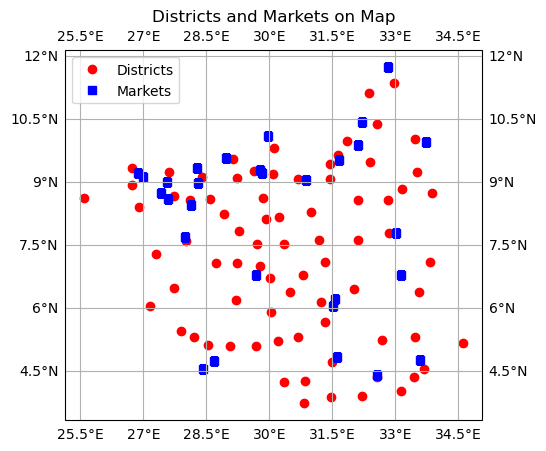

In [2]:


# Sample data for df1 (districts) and df2 (markets)
data1 = pd.read_csv('data/food_crises_cleaned.csv', parse_dates=['date'])
df1 = data1[['district','centy', 'centx']].drop_duplicates().reset_index(drop=True)
display(data1.shape)
data2 = pd.read_csv('data/wfp_food_prices_ssd.csv', parse_dates=['date'])
df2 = data2[['market', 'latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Create a figure and axis with a Cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot districts as red circles
ax.plot(df1['centx'], df1['centy'], 'ro', label='Districts')

# Plot markets as blue squares
ax.plot(df2['longitude'], df2['latitude'], 'bs', label='Markets')

# Add gridlines and coastlines
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.COASTLINE)

# Set the title and legend
plt.title('Districts and Markets on Map')
plt.legend()

# Show the plot
plt.show()


In [3]:
data1 = pd.read_csv('data/food_crises_cleaned.csv', parse_dates=['date'])
df_districts = data1[['district','centy', 'centx']].drop_duplicates().dropna(subset=['centy', 'centx']).reset_index(drop=True)

data2 = pd.read_csv('data/wfp_food_prices_ssd.csv', parse_dates=['date'])
data2['date'] = data2['date'].dt.strftime('%Y-%m-01')
data2['date'] = pd.to_datetime(data2['date'])

df_markets = data2[['market', 'latitude', 'longitude']].drop_duplicates().dropna(subset=['latitude', 'longitude']).reset_index(drop=True)

# Create feature vectors for districts and markets
X_districts = df_districts[['centy', 'centx']].values
X_markets = df_markets[['latitude', 'longitude']].values


# Create a NearestNeighbors model with k=1 (closest neighbor)
knn = NearestNeighbors(n_neighbors=1)
knn.fit(X_markets)  # Fit the model on market locations

# Find the index of the closest market for each district
distances, indices = knn.kneighbors(X_districts)

# Assign the closest market to each district
df_districts['Closest_Market'] = df_markets['market'].iloc[indices[:, 0]].values

In [4]:
date_market_counts = data2.groupby(['date', 'market']).size().reset_index(name='count')
date_market_counts

,date,market,count
0,2006-01-01,Konyokonyo,1
1,2006-01-01,Malakal,2
2,2006-02-01,Konyokonyo,1
3,2006-02-01,Malakal,2
4,2006-03-01,Konyokonyo,1
...,...,...,...
2328,2024-02-01,Torit,28
2329,2024-02-01,Wanjok,25
2330,2024-02-01,Wunrok,3
2331,2024-02-01,Yambio,24


# Joining Dataframes
left join will mean that for certain dates there will be multiple entries. IE will require grouby **date** and **Closest_Market**

In [5]:
# drop centy and centx to remove duplicate columns
df_districts = df_districts.drop(['centx','centy'], axis=1)
# Merge dfs
data1 = pd.merge(data1, df_districts, how='left', on='district')
final = pd.merge(data1, data2, how='left', left_on=['date', 'Closest_Market'], right_on=['date','market'])
final.to_csv('data/food_crises_cleaned_with_market_details.csv')
final.tail()


,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
46580,South Sudan,151,Malakal,31.6428,9.658457,2020_02,2020,2,4.0,0.0,...,9.533424,31.660485,non-food,"Fuel (petrol-gasoline, parallel market)",L,actual,Retail,SSP,1000.0,6.1962
46581,South Sudan,151,Malakal,31.6428,9.658457,2020_02,2020,2,4.0,0.0,...,9.533424,31.660485,non-food,Milling cost (sorghum),LCU/3.5kg,actual,Retail,SSP,150.0,0.9294
46582,South Sudan,151,Malakal,31.6428,9.658457,2020_02,2020,2,4.0,0.0,...,9.533424,31.660485,non-food,"Wage (non-qualified labour, non-agricultural)",Day,actual,Retail,SSP,500.0,3.0981
46583,South Sudan,151,Malakal,31.6428,9.658457,2020_02,2020,2,4.0,0.0,...,9.533424,31.660485,oil and fats,Oil (vegetable),L,actual,Retail,SSP,1000.0,6.1962
46584,South Sudan,151,Malakal,31.6428,9.658457,2020_02,2020,2,4.0,0.0,...,9.533424,31.660485,pulses and nuts,Beans (red),KG,actual,Retail,SSP,1000.0,6.1962
